# Basic Usage of Spateo Alignment for 2D Slices

In this tutorial, we will provide a brief introduction to the basic usage of Spateo alignment for 2D slices. We'll assume that you have two consecutive spatial transcriptomics slices, each capturing both gene expression data and spatial coordinates. After slicing and sequencing, the relative coordinates of the cells/spots across sections are often lost. Our goal is to align the two samples in such a way that corresponding cells/spots between them have similar readouts, while also preserving the spatial distributions of spots across the samples.


<div class="alert alert-info">

<strong>See also:</strong>

For a more detailed introduction and better understanding of the method, please check our post:
[Spatial transcriptomics alignment](../../technicals/spatial_transcriptomics_alignment.md#Spatial_transcriptomics_alignment)

</div>

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Running this notebook on:  cuda


2024-08-15 02:46:15.993943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 02:46:16.151609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-15 02:46:16.151640: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-15 02:46:16.876471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Last run with spateo version: 1.0.2.dev524+b8e75b8


# Loading the Data

In this tutorial, we'll be using data from a mouse embryo at the E9.5 developmental stage, obtained using the Stereo-Seq technique. Specifically, we'll work with slices #32 and #33 as our demo data. These slices contain 17,425 and 19,939 cells, respectively. You can download the processed data from the links below. Once downloaded, ensure you place the data in the appropriate directory.

- [Mouse Embryo E9.5 Slice #32](https://drive.google.com/file/d/16gh_vApgzlvrplzbxYe-eODjZhvdNM4Z/view?usp=drive_link)
- [Mouse Embryo E9.5 Slice #33](https://drive.google.com/file/d/1n49YCLeqjTlYyHHBzJKmIisbIau8N9Fp/view?usp=drive_link)

In [3]:
# Load the slices
slice1 = st.read('./data/basic_usage_demo_1.h5ad')
slice2 = st.read('./data/basic_usage_demo_2.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 17425 × 26137
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain'
     uns: '__type', 'cellbin_SpatialDomain_colors', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'spatial',
 AnnData object with n_obs × n_vars = 19939 × 26137
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain'
     uns: '__type', 'cellbin_SpatialDomain_colors', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'spatial')

# (Optional & Recommended) Pre-processing the Data

Before proceeding to the next step, we highly recommend performing some basic quality control, normalization, and feature selection. These preprocessing steps can enhance the stability and performance of downstream applications including the alignment in Spateo package. We follow the standard preprocessing workflow for scRNA-seq data in Scanpy [cite] and process the two slices separately.


In [4]:
# preprocess slice1
sc.pp.filter_cells(slice1, min_genes=10)  # we use min_genes=10 as 100 is too large for ST data
sc.pp.filter_genes(slice1, min_cells=3)
# Saving count data
slice1.layers["counts"] = slice1.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(slice1)
# Logarithmize the data
sc.pp.log1p(slice1)
# annotates highly variable genes
sc.pp.highly_variable_genes(slice1, n_top_genes=2000)

# preprocess slice1
sc.pp.filter_cells(slice2, min_genes=10)
sc.pp.filter_genes(slice2, min_cells=3)
# Saving count data
slice2.layers["counts"] = slice2.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(slice2)
# Logarithmize the data
sc.pp.log1p(slice2)
# annotates highly variable genes
sc.pp.highly_variable_genes(slice2, n_top_genes=2000)

# Visualize the slices before the alignment

We can visualize the spatial distribution of the two slices using spateo's plotting function. As expected, the two slices are not aligned, which poses challenges for downstream 3D analysis.

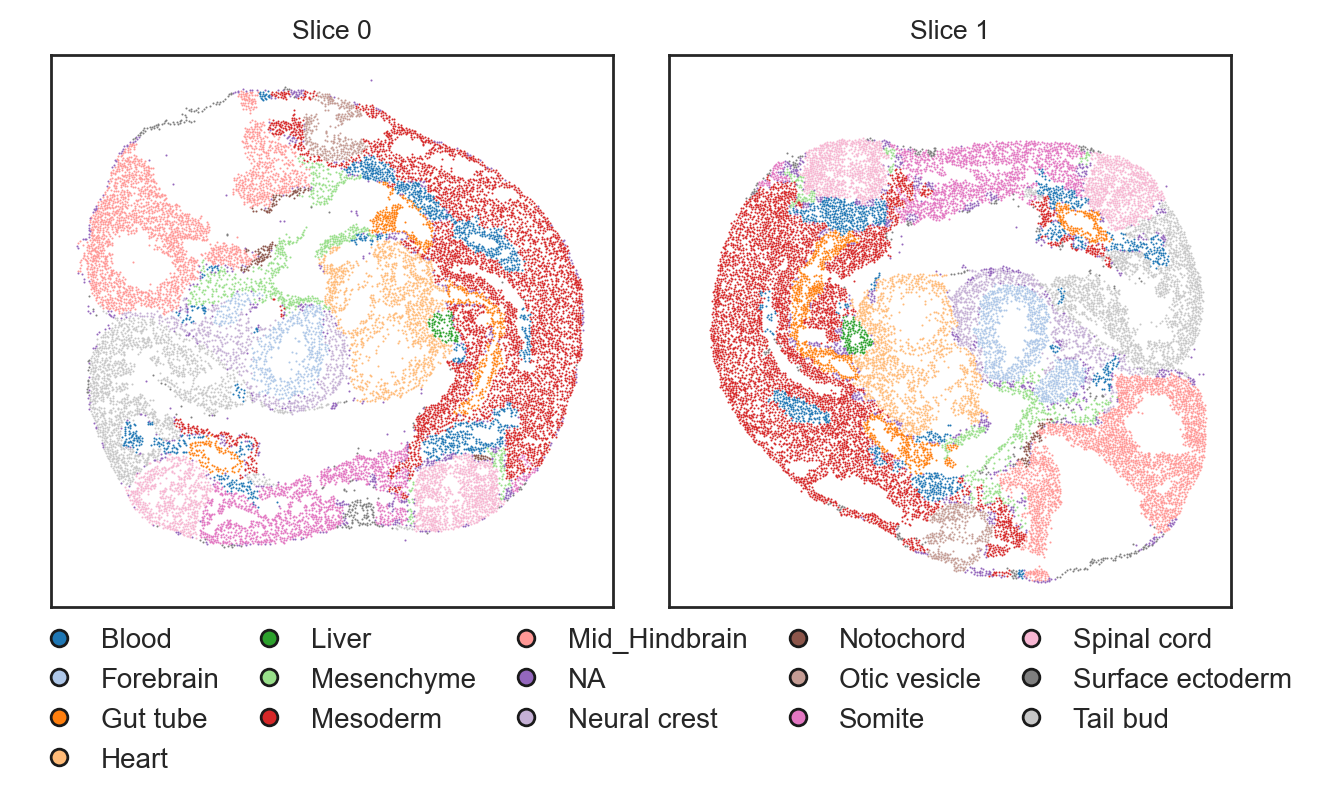

In [8]:
spatial_key = 'spatial'
cluster_key = 'cellbin_SpatialDomain'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
)

# (Optional & Recommended) Perform PCA Between Two Slices

Principal Component Analysis (PCA), a classic linear dimensionality reduction algorithm, can extract the main features from the data while denoising it. Compared to directly using the original high-dimensional gene expression matrix, leveraging PCA features to generate probabilities often results in better performance. Additionally, using features with fewer dimensions can significantly reduce computational overhead when calculating the similarity matrix.

It is important to note that PCA should be performed across both slices, rather than independently on each slice, to ensure that the feature representations are aligned in PCA space. Therefore, in the following steps, we first concatenate the two slices into one dataset and then perform PCA using the function provided by Scanpy. Finally, we extract the corresponding PCA features using the "batch" key.


In [9]:
adata_pca = ad.concat([slice1,slice2], label='batch')
sc.tl.pca(adata_pca)
slice1.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '0'].obsm['X_pca'].copy()
slice2.obsm['X_pca'] = adata_pca[adata_pca.obs['batch'] == '1'].obsm['X_pca'].copy()

<div class="alert alert-info">
<strong>See also:</strong>
    
Spateo is very flexible to the input feature and even support multiple input modalities. For example, we can incorporate label and deep features generated by neural networks. For more detailed introduction, please see the following notebooks

- Incorporating labels: [Incorporate label consistency prior](./Incorporate%20label%20consistency%20prior.ipynb)
- Images: [Alignment between images](./Alignment%20between%20images.ipynb)
- Other input features: [Integrate multimodalities data for alignment](./Integrate%20multimodalities%20data%20for%20alignment.ipynb)
    
</div>

# Spateo Alignment

Spateo alignment is both simple and highly efficient. With a straightforward call to `st.align.morpho_align`, you can obtain aligned slices and the corresponding mapping matrix in just a few seconds (even faster if CUDA is available). In this example, we'll use the highly variable genes extracted earlier and their PCA representations to perform the alignment. Below is an explanation of the function's input parameters:

- **models**: The slices to be aligned, where highly variable genes are used.
- **rep_layer**: The name of the representation to be used.
- **rep_field**: The field in which to store the representation in AnnData.
- **dissimilarity**: The method used to calculate similarity.
- **spatial_key**: The key in `.obsm` of AnnData corresponding to the spatial coordinates.
- **key_added**: The key under which the aligned spatial coordinates are added in `.obsm`.
- **device**: The device to use for computation, either `"cpu"` or `"cuda"`.

In [14]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    # models=[slice1, slice2],
    ## Uncomment this if use highly variable genes
    models=[slice1[:, slice1.var.highly_variable], slice2[:, slice2.var.highly_variable]],  
    ## Uncomment the following if use pca embeddings
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 363 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([1389.4229, 1389.4229])...
|-----------> Scale: tensor([[15312.4160, 10399.6416],
        [ 4967.6079, 10278.4707]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [3.9869s]
|-----> Key Parameters: gamma: 0.9900000095367432; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0196, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.1172s]


<div class="alert alert-info">
<strong>Imporant:</strong>
    
Spateo alignment add three keys in `.obsm`: `key_added`, `key_added + "_rigid"`, and `key_added + "_nonrigid"`.

By default, Spateo will incorporate both rigid and nonrigid (also known as elastic) deformation, and calculate an optimal rigid one based on the both rigid and nonrigid deformaiton. For more details about nonrigid deformation, please refer to the following notebook:
- Nonrigid deformation: [Nonrigid alignment of Spateo for 2D slices](./Nonrigid%20alignment%20of%20Spateo%20for%202D%20slices.ipynb)
</div>

In [15]:
aligned_slices

[AnnData object with n_obs × n_vars = 17425 × 2000
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial', 'log1p', 'hvg'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'spatial', 'align_spatial', 'align_spatial_rigid', 'align_spatial_nonrigid'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 19939 × 2000
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial', 'log1p', 'hvg', 'iter_spatial', 'VecFld_morpho'
     obsm: 'X_pca', 'X_spatial', 'bbo

# Visualization

After the alignment, we can check the alignment results by visualizing the overlay of the two slices. This can be easily done by calling `st.pl.overlay_slices_2d` to visualize the overlay of the two slices. In the following,we visualize both the rigid and nonrigid alignments. The rigid alignment addresses rotation and translation issues, while the nonrigid alignment provides a better fit for the local structure.

<div class="alert alert-warning">
<strong>Warning:</strong>
    
Although nonrigid alignment is better for aligning local structures, it may not always be the best choice in 3D reconstruction. Consecutive slices are inherently different, and it's often unclear whether the deformation in a slice is due to distortions during slicing or reflects the original structure. To help with this, we offer a tutorial on how to determine when to use nonrigid alignment in 3D reconstruction.

When to use nonrigid in 3D reconstruction: [3D reconstruction with pairwise alignment](./3D%20reconstruction%20with%20pairwise%20alignment.ipynb)
    
</div>

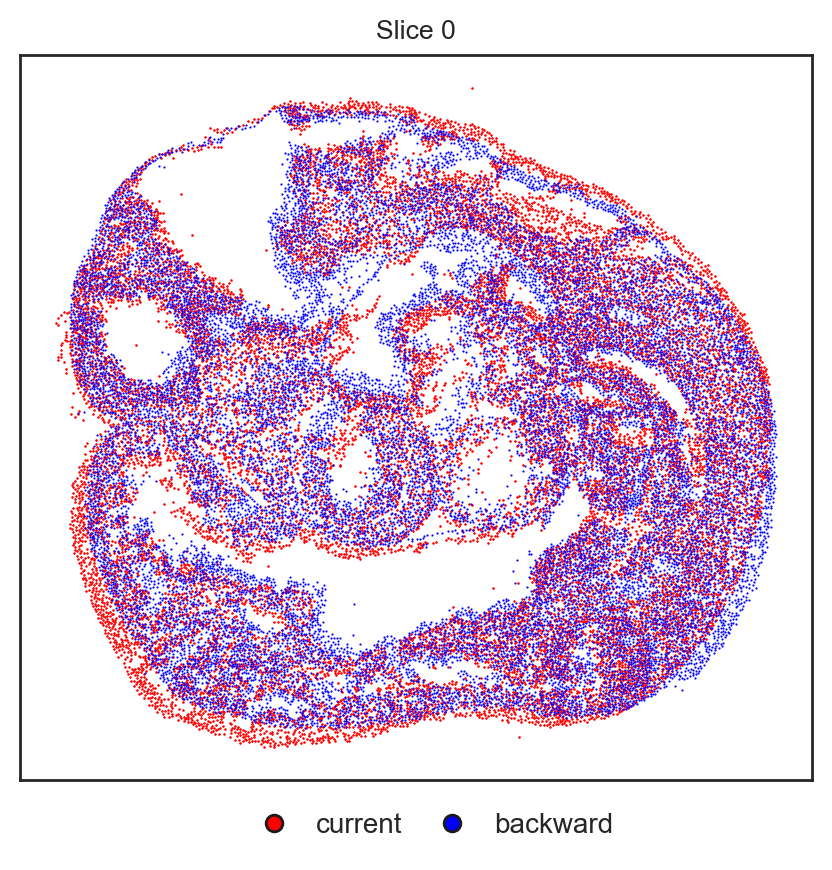

In [16]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=5, overlay_type='backward')

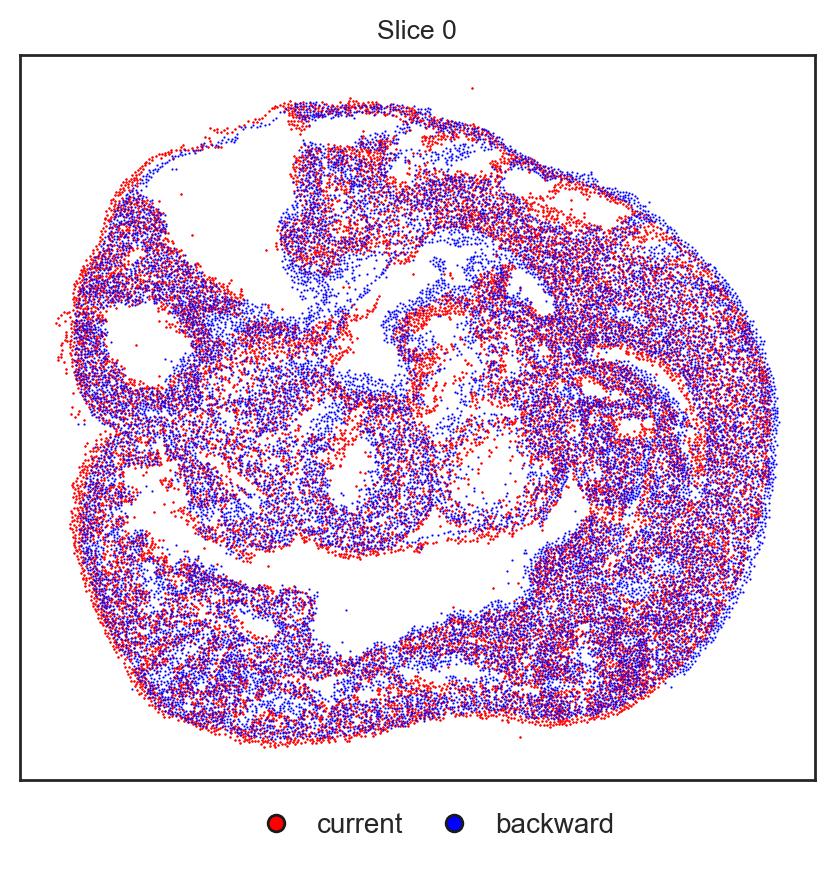

In [17]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=5, overlay_type='backward')

# Conclusion

In this tutorial, we've demonstrated the basic usage of Spateo alignment, which is simple, yet both accurate and efficient. Spateo offers many other powerful features, ranging from 2D slice alignment and 3D spatial transcriptomics reconstruction to 4D spatiotemporal mapping.

Key features include the following with tutorials:

- **Nonrigid Alignment**: Aligns local structures with greater precision.
- **Partial Alignment**: Allows for alignment of specific regions of interest.
- **Sparse Calculation**: Scales up computations for larger datasets.
- **3D reconstruction (Pairwise-Based)**: Reconstructs 3D structures by aligning slices in a pairwise manner.
- **3D reconstruction (Global-Based)**: Performs global alignment across all slices for a more comprehensive 3D reconstruction.
- **3D reconstruction incorporating mesh**: Enhances 3D reconstruction by integrating mesh information, improving structural accuracy.
- **Integrate other modalities**: Allows for the incorporation of various data modalities and features.
- **Align images**: Align two image pairs using Spateo

Additionally, after 3D reconstruction, Spateo integrates advanced 3D visualization functions and tools, enabling users to explore and demonstration their 3D data in a more interactive and detailed manner. Please refer to the next section for more information.
